## Cross Validation and Simple Linear Regression

This project uses cross validation and simple linear regression to build a model and predict employees' salaries based on different employee characteristics or features. The salary.csv file is given containing salaries and employee features. Furthermore a csv file named Salary metadata has the description of each variable found in the salary.csv.

### Import Libraries and Data Read.

In [1]:
import math
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("../data/salary.csv", sep=',')
metadata = pd.read_csv("../data/Salary metadata.csv", sep=';')
data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


In [3]:
pd.set_option('display.max_colwidth', None)
metadata.head(11)

,Variable,Type,Explanation
0,salary,Continuous,Annual salary in dollars
1,exprior,Continuous,Years of experience prior to working in this field
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,"Market value (1 = salary at market value for position, <1 salary lower than market value for position, >1 salary higher than market value for position)"
5,degree,Binary,"Has degree (0 = no, 1 = yes)"
6,otherqual,Binary,"Has other post-secondary qualification (0 = no, 1 = yes)"
7,position,Categorical,"Position (1 = Junior Employee, 2 = Manager, 3 = Executive)"
8,male,Binary,"0 = no, 1 = yes"
9,Field,Categorical,"Field of work (1 = Engineering, 2 = Finance, 3 = Human Resources, 4 = Marketing)"


### Splitting data into training data and test set. 

- The test set is left untouched for now and will later be used to test the model built.
- The training data is analyzed and used to design the simple linear regression model.
- The training data is examined for missing and extreme values.

In [4]:
training_data, testing_data = train_test_split(data, test_size=0.2, random_state=45)

print(f"The shape of split data:\n\nTraining data: {training_data.shape} \nTest set: {testing_data.shape}")

The shape of split data:

Training data: (411, 11) 
Test set: (103, 11)


In [5]:
print(f"The number of missing values with columns: \n{training_data.isnull().sum()}")

The number of missing values with columns: 
salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64


- The training data has one missing value in the salary column. We replace the missing value with the median salary below.
- To examine for extreme values, the descriptive statistics are used.

In [6]:
np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
training_data.salary.replace(np.nan, training_data.salary.median(), inplace=True)

In [8]:
continuous_data_columns = ['salary', 'exprior', 'yearsworked', 'yearsrank', 'market', 'yearsabs'] 
training_data[continuous_data_columns].describe()

,salary,exprior,yearsworked,yearsrank,market,yearsabs
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,51065.372757,2.844282,12.975669,7.255474,0.950341,6.754258
std,12851.685324,4.915390,9.441186,6.479645,0.149323,16.399448
min,29000.000000,0.000000,0.000000,0.000000,0.720000,0.000000
25%,39993.000000,0.000000,4.000000,2.000000,0.850000,0.000000
50%,50257.500000,0.000000,11.000000,5.000000,0.920000,1.000000
75%,60685.031250,4.000000,22.000000,12.000000,1.020000,2.000000
max,96156.000000,25.000000,35.000000,25.000000,1.330000,118.000000


In [9]:
training_data[['degree', 'otherqual', 'position', 'male', 'Field']].astype('category').describe(include='all')

,degree,otherqual,position,male,Field
count,411,411,411,411,411
unique,2,2,3,2,4
top,1,0,3,1,2
freq,399,394,167,315,107


- Yearsabs column representing the number of years absent from work (e.g. due to illness / child rearing / personal reasons) has extreme values with 75-percentile of 2 and maximum of 118 years.
- The outliers are identified for all continuous variables using the percentiles and interquatile range and are replaced with the median below.

In [10]:
for column in continuous_data_columns:
    q3, q1 = np.percentile(training_data[column], [75, 25])
    iqr = q3 - q1
    training_data.loc[(training_data[column] > (q3 + 1.5*iqr)), column] = training_data[column].median()
    training_data.loc[(training_data[column] < (q1 - 1.5*iqr)), column] = training_data[column].median()

### Exploratory Data Visualisation

- The exploratory data visualization is used to summarize the characteristics of different features.
- We first plot histograms representing the distribution of variables.
- Later on a scatterplot is plotted to show the relationship between years worked and employees' salary.

In [11]:
def hist_plotter(ax, column, color, title, label):
    plot = ax.hist(column, bins=20, align='right', color=color, edgecolor='black', linewidth=0.5)
    title = ax.set_title(title, fontweight='bold')
    xlabel = ax.set_xlabel(label, fontweight='bold')
    return plot, title, xlabel

Text(0.09, 0.5, 'Number of Employees')

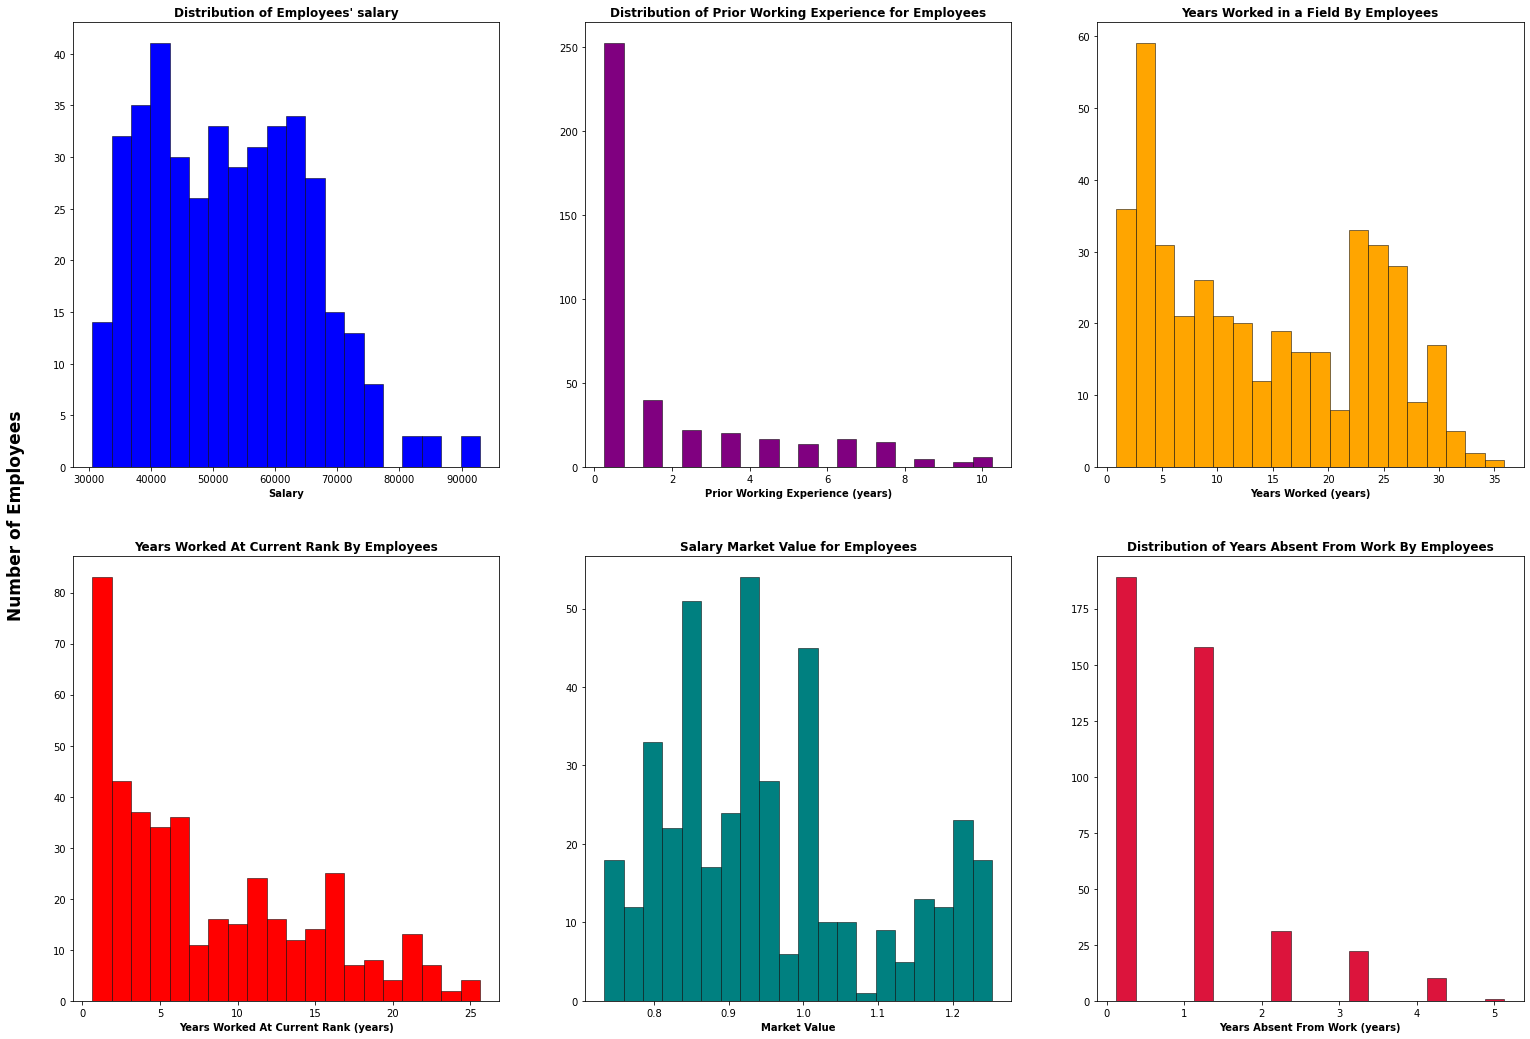

In [12]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(26,18))

hist_plotter(ax0, training_data.salary, "blue", "Distribution of Employees' salary", "Salary")
hist_plotter(ax1, training_data.exprior, "purple", "Distribution of Prior Working Experience for Employees", "Prior Working Experience (years)" )
hist_plotter(ax2, training_data.yearsworked, "orange", "Years Worked in a Field By Employees","Years Worked (years)")
hist_plotter(ax3, training_data.yearsrank, "red", "Years Worked At Current Rank By Employees", "Years Worked At Current Rank (years)")
hist_plotter(ax4, training_data.market, "teal", "Salary Market Value for Employees", "Market Value")
hist_plotter(ax5, training_data.yearsabs, "crimson", "Distribution of Years Absent From Work By Employees", "Years Absent From Work (years)")

fig.text(0.09, 0.5, 'Number of Employees', va='center', rotation='vertical', fontweight='bold', fontsize=17)

#### The following distributions are left skewed and can be log transformed to remove the skewness from the original data:
- Distribution of prior working experience for employees.
- Distribution for years worked at current rank by employees.
- Distribution of years absent from work by employees.

#### The following distributions are bimodal and can also be log transformed to normalize them:
- Distribution of employees' salary.
- Distribution of years worked in the field for employees.
- Distribution of salary market value for employees.

The Ordinary Least Squares method for linear regression estimation does not require the normality assumptions, thus non of the above variables are transformed for the model.

#### Scatterplot representing the relationship between years worked and employees' salary.

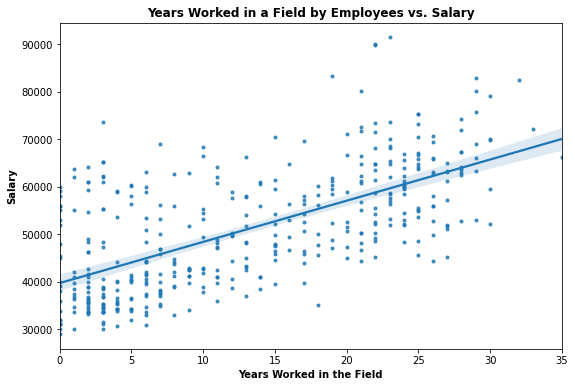

In [13]:
plt.rc('figure', figsize=(9,6))
sns.regplot(x='yearsworked' , y = 'salary', marker='.', data=training_data)
_ = plt.xlabel('Years Worked in the Field', fontweight='bold')
_ = plt.ylabel('Salary', fontweight='bold')
_ = plt.title('Years Worked in a Field by Employees vs. Salary', fontweight='bold')
plt.show()

### Simple linear regression for Salary and predictor variable Years Worked.

The simple linear regression model using the Ordinary Least Square method is created using the predictor variable of years worked and dependent variable salary. The Ordinary Least Square does not have an intercept included by default. Additional constants of 1's are added to the dependent variable to not constrain the regression line into only passing through the origin. This will prevent an overall bias by forcing the residual mean to equal zero.

In [14]:
X = training_data.yearsworked
y = training_data.salary

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

predicted_y = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     293.6
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           5.37e-50
Time:                        17:23:16   Log-Likelihood:                -4353.8
No. Observations:                 411   AIC:                             8712.
Df Residuals:                     409   BIC:                             8720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.971e+04    811.253     48.948      

### Determining the significance of the model to predict the dependent variable.

- The model has an R-squared of 0.418, meaning that 41.8% of variations in our data is explained by the relationship between salary and years worked. 58.2 % of variations is explained by other factors. 
- The t-statistics are calculated with the hypothesis assumption that:
   - The null hypothesis H0 stating that the independent variable(X) has no influence on the dependent variable(Y) is true.
- The t-statistic is very large for both the constant variable and yearsworked variable, with p-values of 0, thus the null hypothesis is rejected. The model's prediction is significant.


### Determining the relationship between years worked and salary using the unstandardized coefficient from the model. 

- The constant term representing the average starting salary for employees with no work experience is `$`39 710.00.
- The coefficient term of year worked representing the gradient or slope of the linear regression model is 866.60. 
- The positive gradient shows that an increase in the number of years worked by employees will influence an increase in employees' salary. 
- For one year of years worked, an employee salary will raise by `$`866.60.

### Model's Confidence Intervals.

The linear regression model uses the 95% confidence interval meaning: 
- For a randomly selected sample, 95% of the time, the sample will contain a true population parameter such as the mean.
- The intervals upper and lower bound represented by [0.025, 0.975] in the model summary, gives us the interval values in which the mean would fall in between for constant and years worked of samples. This interval contains the true mean 95% of the time.

### Predicting the expected salary for employees with 12 years and 80 years work experience.

In [25]:
new_x_arr = [(1, 12), (1, 80)]
predicted_salary = model.predict(new_x_arr)

print(f"The expected salary for an employee with a number of years of work experience: \n{12} years: ${predicted_salary[0]} \n{80} years: ${predicted_salary[1]}.")

The expected salary for an employee with a number of years of work experience: 
12 years: $50108.17967798271 
80 years: $109037.1925822674.


- From the training data we have the maximum salary of `$`96 156, of an employee with 12 years work experience.
- However our model predicts that an employee with 12 years work experience will likely earn `$`50 108.18. 
- The salary of an employee with 80 years work experience is `$`12 881.19 greater than an employee with 12 years work experience.
- Using the constant value, the minimum salary the model can predict is `$`37 910 despite having minimum salary of `$`29 000.00 from the training data.
- The above points suggest that there is a problem with our model. 

### Characteristics influencing employees' salary. 

To determine other characteristics influencing employees' salary, the Pearson's linear correlation is used below to determine the relationship between other continuous variables and salary.

In [16]:
for column in continuous_data_columns:
    r, p = sp.stats.pearsonr(training_data['salary'], training_data[column])
    print(f"Pearson's Correlation Coefficient {column}: {r} \nP Value: {p}\n")

Pearson's Correlation Coefficient salary: 1.0 
P Value: 0.0

Pearson's Correlation Coefficient exprior: -0.07967625000306564 
P Value: 0.10675908020575947

Pearson's Correlation Coefficient yearsworked: 0.6464292728056084 
P Value: 5.373972829220719e-50

Pearson's Correlation Coefficient yearsrank: 0.629134672361411 
P Value: 1.110182502121457e-46

Pearson's Correlation Coefficient market: 0.3860906044293447 
P Value: 4.645137568827256e-16

Pearson's Correlation Coefficient yearsabs: -0.19826397297995957 
P Value: 5.178097109053099e-05



In our simple linear regression model, only the years worked by employees was considered as the predictor parameter influencing the employees' salary, however they are many other factor influencing employees' salaries which are statistically significant as seen from our p-values, these include:

In [17]:
metadata.loc[metadata['Variable'].isin(['market', 'yearsworked','yearsrank', 'yearsabs'])]

,Variable,Type,Explanation
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,"Market value (1 = salary at market value for position, <1 salary lower than market value for position, >1 salary higher than market value for position)"
10,yearsabs,Continuous,Years absent from work (e.g. due to illness / child rearing / personal reasons)


The p-value of years of experience prior to working in the field is higher than 0.05 and is not statistically significant. 
- It indicates a strong evidence that there is no relationship between experience prior and employees' salary. 

The multivariate linear regression can be used to determine the relationship between the statistically significant variables and salary, and build a predictive model with a high R-squared value, less residuals, and incorrect predictions. 

### Fitting the test set to the model.

In [18]:
testing_data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
427,43500.0,6,0,0,1.21,0,0,1,0,3,2
243,54686.0,0,28,7,0.91,1,0,3,1,1,1
61,29500.0,6,0,0,0.79,1,0,1,1,3,0
403,55752.0,0,2,2,1.19,1,0,1,0,4,3
450,63500.0,10,0,0,1.24,1,0,2,0,4,25


In [19]:
print(f"The number of missing values for columns of the testing data: \n{testing_data.isnull().sum()}")

The number of missing values for columns of the testing data: 
salary         0
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64


In [20]:
x_test = testing_data.yearsworked
actual_y_test = testing_data.salary

x_test = sm.add_constant(x_test)
predicted_y_test = model.predict(x_test)

The data used to create the model and it's regression line are plotted in the same axis with the predicted values from the test set. The actual test set data for years worked and employees' salary is also plotted in the same axis to compare the predicted values with actual values.

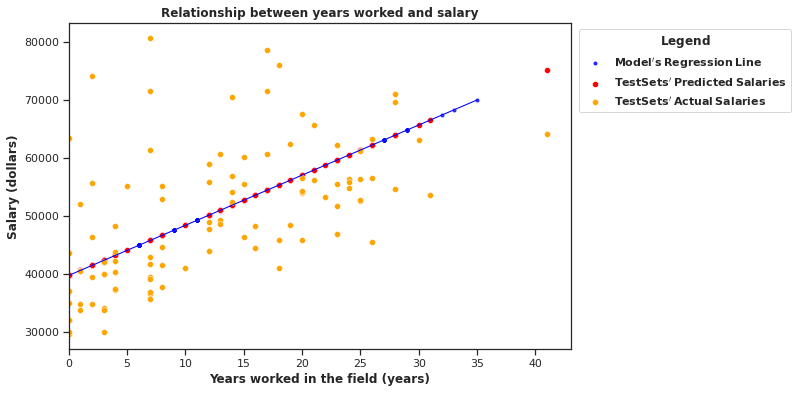

In [21]:
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
_ = sns.regplot(x=X.yearsworked , y=predicted_y, marker='.', color='blue', label= r"$\bf{Model's\> Regression\> Line}$")
_ = sns.scatterplot(x=x_test.yearsworked , y=predicted_y_test, markers='.', color='red', label=r"$\bf{Test Sets'\> Predicted\> Salaries}$")
_ = sns.scatterplot(x=x_test.yearsworked, y=actual_y_test, markers='.', color='orange', label=r"$\bf{Test Sets'\> Actual\> Salaries}$")
plt.xlabel('Years worked in the field (years)', fontweight='bold')
plt.ylabel('Salary (dollars)', fontweight='bold')
plt.title('Relationship between years worked and salary', fontweight='bold')
plt.legend(title=r"$\bf{Legend}$", bbox_to_anchor=(1.45,1))
plt.show()

### Difference in the Root Mean Square Error (RMSE) between the training and test sets.

In [22]:
mse_training = mean_squared_error(training_data.salary, predicted_y)
mse_test = mean_squared_error(testing_data.salary, predicted_y_test)
rmse_training = math.sqrt(mse_training)
rmse_test = math.sqrt(mse_test)

print(f"The difference in the Root Mean Square Error between the training and test sets: ${abs(rmse_training-rmse_test)}.")

The difference in the Root Mean Square Error between the training and test sets: 254.01131069605253 dollars


### Test set fitting conclusion

After the test set is run on the model, the following can be concluded from the prediction, the plot, and the RMSE: 
- The predicted salaries are exactly found along the regression line, these are represented using the red data points on the graph. 
- The actual salaries for the test set are approximately scattered about the regression line, thus the simple linear regression model it under-fits the actual salaries data and perfectly fits the predicted test salaries.
- The difference in the Root Mean Square Error between the training and test sets `$`254.01, since the training and test RMSE are very close, we did not overfit this model.